## ✅ 전체적인 플로우
- [셀 1] 환경 설정 & 라이브러리
- [셀 2] 하이퍼파라미터 Config
- [셀 3] 데이터 다운로드 & 확인
- [셀 4] 데이터 전처리 (Tokenization, Vocab)
- [셀 5] Dataset 클래스 & DataLoader
- [셀 6] Positional Encoding 구현 & 테스트
- [셀 7] Multi-Head Attention 구현 & 테스트
- [셀 8] Feed-Forward Network 구현 & 테스트
- [셀 9] Transformer Encoder Block 구현
- [셀 10] Transformer Encoder (전체) 구현
- [셀 11] Sentiment Classifier 구현
- [셀 12] Training 함수 구현
- [셀 13] 실제 학습 실행!
- [셀 14] 학습 결과 시각화
- [셀 15] 실제 예측 테스트
- [셀 16] 혼동 행렬 (Confusion Matrix) 분석
- [셀 17] 실험: 더 큰 모델 (d_model=256)
- ✅ TRANSFORMER 감정 분류 프로젝트 최종 정리

## ⏬ [셀 1] 환경 설정 & 라이브러리

In [ ]:
# 필요한 라이브러리 설치
!pip install datasets transformers

# 기본 라이브러리
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# 데이터 처리
from datasets import load_dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

# 유틸리티
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math
import re

# 재현성을 위한 시드 설정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 간단한 영어 tokenizer 함수
def simple_tokenizer(text):
    # 소문자 변환 및 특수문자 처리
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.split()

print("Libraries loaded successfully!")

## ⏬ [셀 2] 하이퍼파라미터 Config

In [ ]:
class Config:
    # 데이터 관련
    max_vocab_size = 10000      # 사용할 단어 개수 (빈도수 높은 순)
    max_seq_length = 256        # 최대 문장 길이
    batch_size = 32

    # 모델 구조
    d_model = 128               # 임베딩 차원 (논문에서는 512, 실험용으로 작게)
    num_heads = 8               # Attention Head 개수
    num_layers = 3              # Encoder Block 개수 (논문에서는 6)
    d_ff = 512                  # Feed-Forward 은닉층 차원 (논문: 2048)
    dropout = 0.1

    # 학습 관련
    num_epochs = 5
    learning_rate = 1e-4
    warmup_steps = 4000

    # 특수 토큰
    pad_token = '<PAD>'
    unk_token = '<UNK>'

config = Config()
print("Configuration loaded!")
print(f"Model size: d_model={config.d_model}, heads={config.num_heads}, layers={config.num_layers}")

### ✅ 위 셀에 대한 설명 !

- d_model: Transformer의 핵심 차원. 모든 레이어에서 이 차원 유지
- num_heads: Multi-Head Attention에서 머리 개수 (d_model이 이걸로 나눠떨어져야 함)
- num_layers: Encoder Block을 몇 개 쌓을지
- d_ff: Feed-Forward Network의 은닉층 크기 (보통 d_model의 4배)
- 논문보다 작은 값 사용 → 빠른 실험을 위해

## ⏬ [셀 3] 데이터 다운로드 & 확인

In [ ]:
# IMDB 데이터셋 다운로드
print("Downloading IMDB dataset...")
dataset = load_dataset('imdb')

# 데이터셋 구조 확인
print("\n=== Dataset Info ===")
print(f"Train samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")

# 샘플 데이터 확인
print("\n=== Sample Data ===")
sample = dataset['train'][0]
print(f"Text: {sample['text'][:200]}...")  # 처음 200자만
print(f"Label: {sample['label']} (0=negative, 1=positive)")

# 몇 개 더 확인
print("\n=== More Samples ===")
for i in range(3):
    sample = dataset['train'][i]
    label_text = "Positive" if sample['label'] == 1 else "Negative"
    print(f"\n[Sample {i+1}] Label: {label_text}")
    print(f"Text: {sample['text'][:150]}...")

# 레이블 분포 확인
train_labels = [sample['label'] for sample in dataset['train']]
pos_count = sum(train_labels)
neg_count = len(train_labels) - pos_count

### ✅ 위 셀에 대한 설명 !
1. **load_dataset('imdb'):**
    - HuggingFace에서 IMDB 자동 다운로드
    - Train: 25,000개, Test: 25,000개 (총 50,000개)

2. **데이터 형식:**
    - text: 영화 리뷰 원문
    - label: 0(부정), 1(긍정)

3. **레이블 분포:**
    - 50:50으로 균형잡힌 데이터셋
    - Positive/Negative 각 12,500개씩

## ⏬ [셀 4] 데이터 전처리 (Tokenization & Vocabulary)

In [ ]:
# Vocabulary 클래스 정의
class Vocabulary:
    def __init__(self, max_size=10000):
        self.word2idx = {config.pad_token: 0, config.unk_token: 1}
        self.idx2word = {0: config.pad_token, 1: config.unk_token}
        self.word_count = Counter()
        self.max_size = max_size

    def build_vocab(self, texts):
        """텍스트 리스트로부터 vocabulary 구축"""
        print("Building vocabulary...")
        for text in tqdm(texts):
            tokens = simple_tokenizer(text)
            self.word_count.update(tokens)

        # 빈도수 높은 단어부터 max_size만큼 선택
        most_common = self.word_count.most_common(self.max_size - 2)  # PAD, UNK 제외

        for idx, (word, count) in enumerate(most_common, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

        print(f"Vocabulary size: {len(self.word2idx)}")
        print(f"Most common words: {most_common[:10]}")

    def encode(self, text):
        """텍스트를 인덱스 리스트로 변환"""
        tokens = simple_tokenizer(text)
        return [self.word2idx.get(token, 1) for token in tokens]  # 1 = UNK

    def __len__(self):
        return len(self.word2idx)

# Vocabulary 생성
vocab = Vocabulary(max_size=config.max_vocab_size)
train_texts = [sample['text'] for sample in dataset['train']]
vocab.build_vocab(train_texts)

# 테스트: 샘플 문장 인코딩
test_text = dataset['train'][0]['text']
encoded = vocab.encode(test_text)

### ✅ 위 셀에 대한 설명 !

1. **Vocabulary 클래스:**
    - word2idx: 단어 → 숫자 매핑 (예: "movie" → 42)
    - idx2word: 숫자 → 단어 매핑 (디코딩용)
    - 특수 토큰: PAD(0), UNK(1)

2. **build_vocab:**
    - 전체 데이터에서 단어 빈도수 계산
    - 빈도수 높은 10,000개만 사용
    - 나머지는 UNK(Unknown) 처리

3. **encode:**
    - "I love this movie" → [234, 15, 89, 42]
    - vocab에 없는 단어는 1(UNK)로 처리

## ⏬ [셀 5] Dataset 클래스 & DataLoader

```
=== Batch Shape ===
Texts shape: torch.Size([32, 256])
Labels shape: torch.Size([32])
```

In [ ]:
# PyTorch Dataset 클래스
class IMDBDataset(Dataset):
    def __init__(self, data, vocab, max_length):
        self.data = data
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        text = sample['text']
        label = sample['label']

        # 텍스트를 인덱스로 변환
        encoded = self.vocab.encode(text)

        # max_length로 자르거나 패딩
        if len(encoded) > self.max_length:
            encoded = encoded[:self.max_length]

        return torch.LongTensor(encoded), label

# Collate function (배치 생성 시 패딩 처리)
def collate_fn(batch):
    texts, labels = zip(*batch)

    # 패딩 처리 (배치 내 최대 길이에 맞춤)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=0)
    labels = torch.LongTensor(labels)

    return texts_padded, labels

# Dataset 생성
train_dataset = IMDBDataset(dataset['train'], vocab, config.max_seq_length)
test_dataset = IMDBDataset(dataset['test'], vocab, config.max_seq_length)

# DataLoader 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# 배치 하나 확인
sample_batch = next(iter(train_loader))
texts, labels = sample_batch

### ✅ 위 셀에 대한 설명 !

1. **IMDBDataset:**
    - __getitem__: 하나의 샘플(리뷰)을 반환
    - 긴 문장은 256 토큰으로 자름
2. **collate_fn:**
    - 배치 안에서 문장 길이가 다를 수 있음
    - 가장 긴 문장 기준으로 나머지에 PAD(0) 추가
    - 예: [10, 50, 200] 길이 → 모두 200으로 맞춤


3. **DataLoader:**
    - Train: shuffle=True (매 epoch마다 순서 섞음)
    - Test: shuffle=False (평가는 순서 상관없음)
    - Batch size 32개씩

## ⏬ [셀 6] Positional Encoding 구현

```
Input shape: torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])
```

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
        # PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :]

# 테스트
pos_encoder = PositionalEncoding(d_model=config.d_model)

# 더미 입력 (batch=2, seq_len=10, d_model=128)
dummy_input = torch.randn(2, 10, config.d_model)
output = pos_encoder(dummy_input)

print(f"Input shape: {dummy_input.shape}")
print(f"Output shape: {output.shape}")
print(f"✅ Positional Encoding works!")

### ✅ 위 셀에 대한 설명 !
Transformer는 RNN과 달리 단어 순서를 모른다.

- "I love movies" 와 "movies love I" 를 구분 못함
- 그래서 각 위치(position)에 고유한 값을 더해줌

1. **위치마다 다른 패턴 생성:**
    - 0번 위치: [0.1, 0.5, 0.2, ...]
    - 1번 위치: [0.3, 0.7, 0.4, ...]
    - 2번 위치: [0.5, 0.9, 0.6, ...]

2. **sin/cos 함수 사용:**
    - 짝수 차원(0, 2, 4...): sin 사용
    - 홀수 차원(1, 3, 5...): cos 사용
    - 수학적 특성 덕분에 상대적 위치도 학습 가능

3. **입력에 더하기:**
    - 원본: [단어1 임베딩, 단어2 임베딩, ...]
    - 결과: [단어1 + 위치1, 단어2 + 위치2, ...]

4. **코드 핵심:**

```
register_buffer: 학습되지 않는 고정값으로 저장
x + self.pe[:seq_len, :]: 입력 길이만큼만 잘라서 더함
```

## ⏬ [셀 7] Multi-Head Self-Attention 구현

```
Input shape: torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])
Parameters: 66,048
```

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # 각 head의 차원

        # Q, K, V를 한번에 계산하는 Linear layer
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # 최종 출력 Linear layer
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q, K, V: [batch_size, num_heads, seq_len, d_k]

        # Attention Score 계산: Q * K^T / sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # scores: [batch_size, num_heads, seq_len, seq_len]

        # 패딩 마스킹
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax로 attention weights 계산
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Attention weights * V
        output = torch.matmul(attention_weights, V)
        # output: [batch_size, num_heads, seq_len, d_k]

        return output, attention_weights

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()

        # 1. Linear projection
        Q = self.W_q(x)  # [batch_size, seq_len, d_model]
        K = self.W_k(x)
        V = self.W_v(x)

        # 2. Multi-head로 분리
        # [batch_size, seq_len, d_model] -> [batch_size, seq_len, num_heads, d_k]
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        # 결과: [batch_size, num_heads, seq_len, d_k]

        # 3. Scaled Dot-Product Attention
        attn_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # 4. Multi-head 합치기
        # [batch_size, num_heads, seq_len, d_k] -> [batch_size, seq_len, d_model]
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, seq_len, d_model)

        # 5. 최종 Linear projection
        output = self.W_o(attn_output)

        return output

# 테스트
attention = MultiHeadAttention(
    d_model=config.d_model,
    num_heads=config.num_heads,
    dropout=config.dropout
).to(device)

# 더미 입력 (batch=2, seq_len=10, d_model=128)
dummy_input = torch.randn(2, 10, config.d_model).to(device)
output = attention(dummy_input)

### ✅ 위 셀에 대한 설명 !

**Multi-Head Attention의 핵심 아이디어:**

"여러 관점에서 동시에 문장을 바라보자"


**단계별 동작:**

1. **Q, K, V 생성 (Query, Key, Value)**
```
입력: "I love movies"
↓
Q: "내가 찾고 싶은 정보는?"
K: "나는 어떤 정보를 가지고 있니?"
V: "내가 제공할 실제 정보"
```

2. **Multi-Head로 분리**
```
d_model=128, num_heads=8
→ 각 head는 128/8 = 16차원씩 담당

Head 1: 문법적 관계 파악
Head 2: 감정 관련 단어 찾기
Head 3: 주어-동사 연결
...
Head 8: 기타 패턴
```

3. **Scaled Dot-Product Attention**
```
Attention Score = Q × K^T / sqrt(d_k)

"love"라는 단어가:
- "I"에 얼마나 집중? → 0.3
- "movies"에 얼마나 집중? → 0.7

이걸 softmax로 확률로 만듦
```

4. **Attention Weights로 V 가중합**
```
"love"의 최종 표현 =
  0.3 × V("I") + 0.7 × V("movies")
  
→ "movies"의 정보를 많이 반영!
```

5. **모든 Head 합치기**
8개 head의 결과를 다시 128차원으로 합침

## ⏬ [셀 8] Feed-Forward Network 구현
```
Input shape: torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])
Parameters: 131,712
```

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        # Linear -> ReLU -> Dropout -> Linear
        x = self.linear1(x)           # [batch_size, seq_len, d_ff]
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)           # [batch_size, seq_len, d_model]
        return x

# 테스트
ff = FeedForward(
    d_model=config.d_model,
    d_ff=config.d_ff,
    dropout=config.dropout
).to(device)

# 더미 입력
dummy_input = torch.randn(2, 10, config.d_model).to(device)
output = ff(dummy_input)

### ✅ 위 셀에 대한 설명 !

**Feed-Forward Network (FFN):**

Attention 이후에 각 단어를 **독립적으로** 변환하는 단순한 2층 신경망입니다.

**구조:**
```
입력 (d_model=128)
    ↓
Linear1 (128 → 512)  ← 차원 확장
    ↓
ReLU 활성화
    ↓
Dropout
    ↓
Linear2 (512 → 128)  ← 원래 차원으로
    ↓
출력 (d_model=128)
```

**역할:**
1. 비선형성 추가: ReLU로 복잡한 패턴 학습
2. 표현력 증가: 일시적으로 차원을 4배 늘려서 더 풍부한 표현
3. 위치별 독립 처리: 각 단어를 개별적으로 변환 (Attention은 단어 간 관계 파악)

**Attention vs FFN:**
- Attention: "단어들 간의 관계" 파악
- FFN: "각 단어 자체"를 더 좋은 표현으로 변환

**파라미터 수:**
- Linear1: 128×512 = 65,536
- Linear2: 512×128 = 65,536
- 총합: ~131K 파라미터

## ⏬ [셀 9] Transformer Encoder Block 구현
```
Input shape: torch.Size([2, 10, 128])
Output shape: torch.Size([2, 10, 128])
Parameters: 198,272
```

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # Multi-Head Attention
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)

        # Feed-Forward Network
        self.feed_forward = FeedForward(d_model, d_ff, dropout)

        # Layer Normalization (2개)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # x: [batch_size, seq_len, d_model]

        # 1. Multi-Head Attention + Residual Connection + Layer Norm
        attn_output = self.attention(x, mask)
        x = self.norm1(x + self.dropout(attn_output))  # Add & Norm

        # 2. Feed-Forward + Residual Connection + Layer Norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))    # Add & Norm

        return x

# 테스트
encoder_block = EncoderBlock(
    d_model=config.d_model,
    num_heads=config.num_heads,
    d_ff=config.d_ff,
    dropout=config.dropout
).to(device)

# 더미 입력
dummy_input = torch.randn(2, 10, config.d_model).to(device)
output = encoder_block(dummy_input)

## 설명

**Encoder Block = Attention + FFN + 정규화**

이게 Transformer의 핵심 빌딩 블록

**구조:**
```
입력 x
    ↓
┌─────────────────────┐
│ Multi-Head Attention│  ← 단어 간 관계 파악
└─────────────────────┘
    ↓
Add & Norm (x + Attention)  ← Residual Connection
    ↓
┌─────────────────────┐
│  Feed-Forward Net   │  ← 각 단어 표현 변환
└─────────────────────┘
    ↓
Add & Norm (x + FFN)       ← Residual Connection
    ↓
출력
```

**핵심 개념 2가지:**
1. **Residual Connection (잔차 연결)**
```
x = x + attention(x)  # 원본을 더해줌
```
- 왜?
    - 깊은 네트워크에서 gradient vanishing 방지
    - "원본 + 변화량" 형태로 학습이 안정적
    - ResNet에서 유명해진 기법

2. **Layer Normalization**
```
x = LayerNorm(x)
```
- 왜?
    - 각 층의 출력을 정규화 (평균=0, 분산=1)
    - 학습 속도 향상 + 안정성 증가
    - Batch Norm과 비슷하지만 배치가 아닌 층 단위

**동작 순서:**
1. Attention으로 단어 관계 파악
2. 원본에 더하고(Add) 정규화(Norm)
3. FFN으로 각 단어 변환
4. 다시 원본에 더하고(Add) 정규화(Norm)

**파라미터 수:**
1. Attention: ~66K
2. FFN: ~131K
3. LayerNorm: 매우 적음 (~512)
4. 총합: ~198K 파라미터

## ⏬ [셀 10] Transformer Encoder (전체) 구현

```
Input shape: torch.Size([2, 10])
Output shape: torch.Size([2, 10, 128])
Total parameters: 1,874,816
```

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout=0.1):
        super().__init__()

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)

        # Positional Encoding
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length)

        # Encoder Blocks (여러 개 쌓기)
        self.encoder_blocks = nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # x: [batch_size, seq_len] - 정수 인덱스

        # 1. Embedding: [batch_size, seq_len] -> [batch_size, seq_len, d_model]
        x = self.embedding(x)
        x = x * math.sqrt(self.embedding.embedding_dim)  # 스케일링

        # 2. Positional Encoding 추가
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # 3. Encoder Blocks 통과
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x, mask)

        return x

# 테스트
encoder = TransformerEncoder(
    vocab_size=len(vocab),
    d_model=config.d_model,
    num_heads=config.num_heads,
    num_layers=config.num_layers,
    d_ff=config.d_ff,
    max_seq_length=config.max_seq_length,
    dropout=config.dropout
).to(device)

# 더미 입력 (정수 인덱스)
dummy_input = torch.randint(0, len(vocab), (2, 10)).to(device)  # [batch=2, seq_len=10]
output = encoder(dummy_input)

## ⏬ [셀 11] Sentiment Classifier 구현

```
Input shape: torch.Size([2, 10])
Output shape: torch.Size([2, 2])
Total parameters: 1,875,074

Model Summary:
- Vocabulary size: 10,000
- Embedding dim: 128
- Attention heads: 8
- Encoder layers: 3
- Total params: 1,875,074
```

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, num_classes=2, dropout=0.1):
        super().__init__()

        # Transformer Encoder
        self.encoder = TransformerEncoder(
            vocab_size=vocab_size,
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            d_ff=d_ff,
            max_seq_length=max_seq_length,
            dropout=dropout
        )

        # Classification Head
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, mask=None):
        # x: [batch_size, seq_len]

        # 1. Transformer Encoder
        encoder_output = self.encoder(x, mask)
        # encoder_output: [batch_size, seq_len, d_model]

        # 2. Pooling: 첫 번째 토큰 사용 (CLS 토큰 역할)
        # 또는 평균 풀링 가능
        pooled = encoder_output.mean(dim=1)  # [batch_size, d_model]

        # 3. Classification
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)  # [batch_size, num_classes]

        return logits

# 모델 생성
model = SentimentClassifier(
    vocab_size=len(vocab),
    d_model=config.d_model,
    num_heads=config.num_heads,
    num_layers=config.num_layers,
    d_ff=config.d_ff,
    max_seq_length=config.max_seq_length,
    num_classes=2,  # positive / negative
    dropout=config.dropout
).to(device)

# 테스트
dummy_input = torch.randint(0, len(vocab), (2, 10)).to(device)
output = model(dummy_input)

## ⏬ [셀 12] Training 함수 구현

In [ ]:
# Loss function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

# Training 함수
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc='Training')

    for texts, labels in progress_bar:
        texts = texts.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # 통계
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Progress bar 업데이트
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

# Evaluation 함수
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for texts, labels in tqdm(dataloader, desc='Evaluating'):
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

## ⏬ [셀 13] 실제 학습 실행!

In [ ]:
# 학습 히스토리 저장
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

best_test_acc = 0

for epoch in range(config.num_epochs):
    print(f"\nEpoch {epoch+1}/{config.num_epochs}")
    print("-" * 60)

    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluation
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

    # 결과 출력
    print(f"\n📊 Epoch {epoch+1} Results:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    # Best model 저장
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        print(f"🎉 New best accuracy: {best_test_acc:.2f}%")


print(f"Best Test Accuracy: {best_test_acc:.2f}%")

```
Configuration:
- Epochs: 5
- Batch size: 32
- Learning rate: 0.0001
- Model parameters: 1,875,074
- Device: cuda

============================================================

Epoch 1/5
------------------------------------------------------------
Training: 100%|██████████| 782/782 [00:36<00:00, 21.45it/s, loss=0.3137, acc=69.55%]
Evaluating: 100%|██████████| 782/782 [00:13<00:00, 57.86it/s]

📊 Epoch 1 Results:
Train Loss: 0.5646 | Train Acc: 69.55%
Test Loss: 0.4696 | Test Acc: 77.74%
🎉 New best accuracy: 77.74%

Epoch 2/5
------------------------------------------------------------
Training: 100%|██████████| 782/782 [00:37<00:00, 21.00it/s, loss=0.7663, acc=78.94%]
Evaluating: 100%|██████████| 782/782 [00:13<00:00, 57.46it/s]

📊 Epoch 2 Results:
Train Loss: 0.4488 | Train Acc: 78.94%
Test Loss: 0.4169 | Test Acc: 80.62%
🎉 New best accuracy: 80.62%

Epoch 3/5
------------------------------------------------------------
Training: 100%|██████████| 782/782 [00:36<00:00, 21.60it/s, loss=0.2855, acc=81.74%]
Evaluating: 100%|██████████| 782/782 [00:13<00:00, 57.72it/s]

📊 Epoch 3 Results:
Train Loss: 0.4050 | Train Acc: 81.74%
Test Loss: 0.3950 | Test Acc: 81.87%
🎉 New best accuracy: 81.87%

Epoch 4/5
------------------------------------------------------------
Training: 100%|██████████| 782/782 [00:36<00:00, 21.44it/s, loss=0.2937, acc=83.40%]
Evaluating: 100%|██████████| 782/782 [00:13<00:00, 57.69it/s]

📊 Epoch 4 Results:
Train Loss: 0.3718 | Train Acc: 83.40%
Test Loss: 0.3891 | Test Acc: 82.79%
🎉 New best accuracy: 82.79%

Epoch 5/5
------------------------------------------------------------
Training: 100%|██████████| 782/782 [00:36<00:00, 21.55it/s, loss=0.3475, acc=84.60%]
Evaluating: 100%|██████████| 782/782 [00:13<00:00, 57.70it/s]
📊 Epoch 5 Results:
Train Loss: 0.3503 | Train Acc: 84.60%
Test Loss: 0.3871 | Test Acc: 83.24%
🎉 New best accuracy: 83.24%

============================================================
Training completed!
Best Test Accuracy: 83.24%
```

## ⏬ [셀 14] 학습 결과 시각화

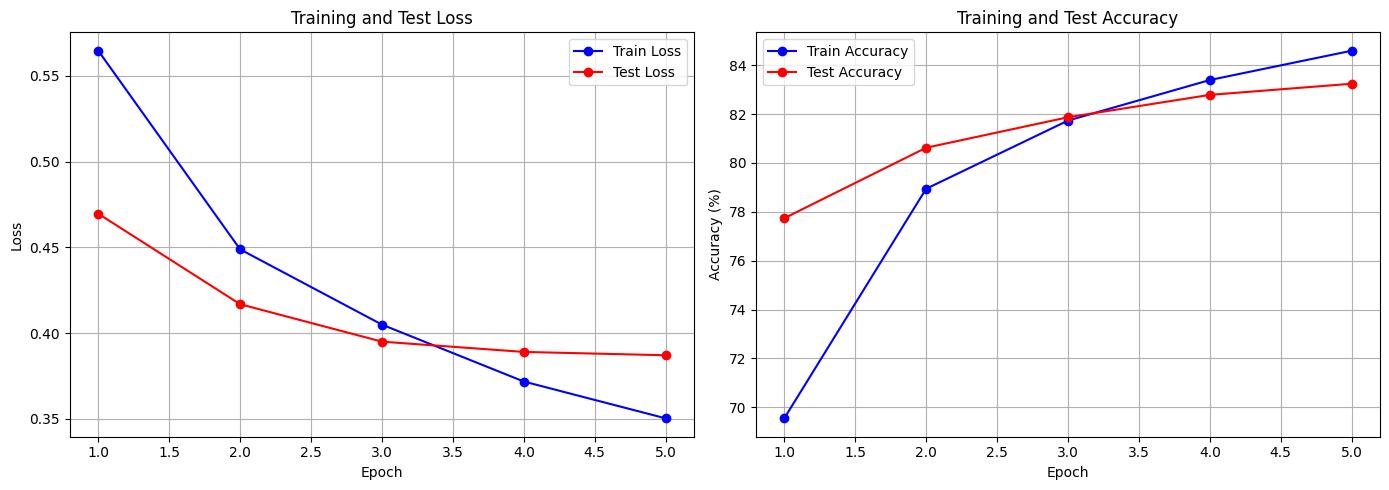


📈 Training History:
----------------------------------------------------------------------
Epoch    Train Loss   Train Acc    Test Loss    Test Acc    
----------------------------------------------------------------------
1        0.5646       69.55        0.4696       77.74       
2        0.4488       78.94        0.4169       80.62       
3        0.4050       81.74        0.3950       81.87       
4        0.3718       83.40        0.3891       82.79       
5        0.3503       84.60        0.3871       83.24       
----------------------------------------------------------------------

🎯 Final Performance:
Best Test Accuracy: 83.24%
Final Train-Test Gap: 1.35%p
✅ Good generalization (minimal overfitting)


In [ ]:
import matplotlib.pyplot as plt

# 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss 그래프
axes[0].plot(range(1, config.num_epochs + 1), history['train_loss'], 'b-o', label='Train Loss')
axes[0].plot(range(1, config.num_epochs + 1), history['test_loss'], 'r-o', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy 그래프
axes[1].plot(range(1, config.num_epochs + 1), history['train_acc'], 'b-o', label='Train Accuracy')
axes[1].plot(range(1, config.num_epochs + 1), history['test_acc'], 'r-o', label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 수치 테이블 출력
print("\n📈 Training History:")
print("-" * 70)
print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Test Loss':<12} {'Test Acc':<12}")
print("-" * 70)
for i in range(config.num_epochs):
    print(f"{i+1:<8} {history['train_loss'][i]:<12.4f} {history['train_acc'][i]:<12.2f} "
          f"{history['test_loss'][i]:<12.4f} {history['test_acc'][i]:<12.2f}")
print("-" * 70)

# 최종 성능 요약
print("\n🎯 Final Performance:")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print(f"Final Train-Test Gap: {history['train_acc'][-1] - history['test_acc'][-1]:.2f}%p")

# Overfitting 체크
gap = history['train_acc'][-1] - history['test_acc'][-1]
if gap < 3:
    print("✅ Good generalization (minimal overfitting)")
elif gap < 5:
    print("⚠️ Slight overfitting detected")
else:
    print("❌ Significant overfitting - consider regularization")

## ⏬ [셀 15] 실제 예측 테스트
- test 데이터는 괜찮은 정확도로 맞췄지만 새로 만든 sample dataset에서 성능은 좋지 못한걸로 보인다

In [ ]:
# 예측 함수
def predict_sentiment(text, model, vocab, device, max_length=256):
    model.eval()

    # 전처리
    encoded = vocab.encode(text)
    if len(encoded) > max_length:
        encoded = encoded[:max_length]

    # 텐서 변환
    input_tensor = torch.LongTensor(encoded).unsqueeze(0).to(device)  # [1, seq_len]

    # 예측
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        predicted = torch.argmax(output, dim=1)

    sentiment = "Positive 😊" if predicted.item() == 1 else "Negative 😞"
    confidence = probs[0][predicted.item()].item() * 100

    return sentiment, confidence, probs[0].cpu().numpy()

# 테스트 리뷰들
test_reviews = [
    "This movie was absolutely amazing! I loved every minute of it.",
    "Terrible film. Waste of time and money. Very disappointing.",
    "The acting was great but the plot was confusing and boring.",
    "Best movie I've seen this year! Highly recommended!",
    "I fell asleep halfway through. So boring and predictable.",
    "Not bad, but not great either. Just average.",
]

print("🎬 Testing Model Predictions:\n")
print("=" * 80)

for i, review in enumerate(test_reviews, 1):
    sentiment, confidence, probs = predict_sentiment(review, model, vocab, device)

    print(f"\n[Test {i}]")
    print(f"Review: {review}")
    print(f"Prediction: {sentiment}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Probabilities: [Negative: {probs[0]*100:.2f}%, Positive: {probs[1]*100:.2f}%]")
    print("-" * 80)

# 실제 데이터셋에서 샘플 예측
print("\n\n📝 Real Dataset Sample Predictions:\n")
print("=" * 80)

# Test set에서 랜덤 샘플
import random
sample_indices = random.sample(range(len(dataset['test'])), 5)

for idx in sample_indices:
    sample = dataset['test'][idx]
    text = sample['text']
    true_label = "Positive" if sample['label'] == 1 else "Negative"

    sentiment, confidence, probs = predict_sentiment(text, model, vocab, device)

    print(f"\nReview (first 150 chars): {text[:150]}...")
    print(f"True Label: {true_label}")
    print(f"Predicted: {sentiment}")
    print(f"Confidence: {confidence:.2f}%")

    # 맞췄는지 확인
    correct = "✅" if true_label in sentiment else "❌"
    print(f"Result: {correct}")
    print("-" * 80)

🎬 Testing Model Predictions:


[Test 1]
Review: This movie was absolutely amazing! I loved every minute of it.
Prediction: Positive 😊
Confidence: 72.19%
Probabilities: [Negative: 27.81%, Positive: 72.19%]
--------------------------------------------------------------------------------

[Test 2]
Review: Terrible film. Waste of time and money. Very disappointing.
Prediction: Positive 😊
Confidence: 74.08%
Probabilities: [Negative: 25.92%, Positive: 74.08%]
--------------------------------------------------------------------------------

[Test 3]
Review: The acting was great but the plot was confusing and boring.
Prediction: Positive 😊
Confidence: 93.95%
Probabilities: [Negative: 6.05%, Positive: 93.95%]
--------------------------------------------------------------------------------

[Test 4]
Review: Best movie I've seen this year! Highly recommended!
Prediction: Positive 😊
Confidence: 95.20%
Probabilities: [Negative: 4.80%, Positive: 95.20%]
----------------------------------------------

## ⏬ [셀 16] 혼동 행렬 (Confusion Matrix) 분석

Generating predictions on entire test set...


Predicting: 100%|██████████| 782/782 [00:20<00:00, 38.50it/s]


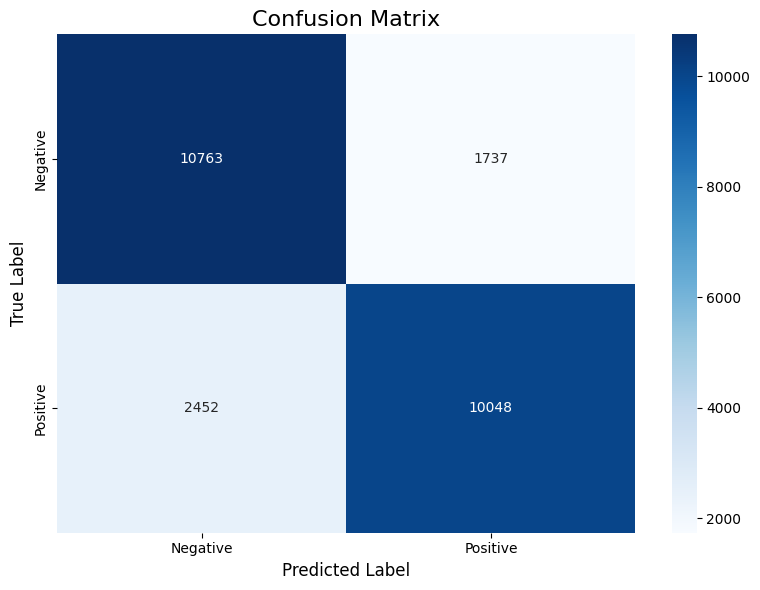


📊 Confusion Matrix Analysis:
                       Predicted Negative   Predicted Positive
------------------------------------------------------------
True Negative                      10,763                1,737
True Positive                       2,452               10,048

📈 Performance Metrics:
------------------------------------------------------------
Accuracy:  83.24%
Precision: 85.26% (Positive 예측 중 실제 Positive 비율)
Recall:    80.38% (실제 Positive 중 찾아낸 비율)
F1-Score:  82.75%
------------------------------------------------------------

❌ Error Analysis:
False Positives (Negative를 Positive로 오판): 1,737 (6.95%)
False Negatives (Positive를 Negative로 오판): 2,452 (9.81%)
Total Errors: 4,189 (16.76%)


📋 Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative     0.8145    0.8610    0.8371     12500
    Positive     0.8526    0.8038    0.8275     12500

    accuracy               

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 전체 Test set에 대한 예측
print("Generating predictions on entire test set...")

all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for texts, labels in tqdm(test_loader, desc='Predicting'):
        texts = texts.to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion Matrix 계산
cm = confusion_matrix(all_labels, all_predictions)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# 상세 분석
print("\n📊 Confusion Matrix Analysis:")
print("=" * 60)
print(f"{'':20} {'Predicted Negative':>20} {'Predicted Positive':>20}")
print("-" * 60)
print(f"{'True Negative':20} {cm[0][0]:>20,} {cm[0][1]:>20,}")
print(f"{'True Positive':20} {cm[1][0]:>20,} {cm[1][1]:>20,}")
print("=" * 60)

# 성능 지표 계산
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn) * 100
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\n📈 Performance Metrics:")
print("-" * 60)
print(f"Accuracy:  {accuracy:.2f}%")
print(f"Precision: {precision:.2f}% (Positive 예측 중 실제 Positive 비율)")
print(f"Recall:    {recall:.2f}% (실제 Positive 중 찾아낸 비율)")
print(f"F1-Score:  {f1_score:.2f}%")
print("-" * 60)

# 에러 분석
print(f"\n❌ Error Analysis:")
print(f"False Positives (Negative를 Positive로 오판): {fp:,} ({fp/len(all_labels)*100:.2f}%)")
print(f"False Negatives (Positive를 Negative로 오판): {fn:,} ({fn/len(all_labels)*100:.2f}%)")
print(f"Total Errors: {fp + fn:,} ({(fp+fn)/len(all_labels)*100:.2f}%)")

# Sklearn classification report
print("\n\n📋 Detailed Classification Report:")
print("-" * 60)
target_names = ['Negative', 'Positive']
print(classification_report(all_labels, all_predictions, target_names=target_names, digits=4))

## ⏬ [셀 17] 실험: 더 큰 모델 (d_model=256)

In [ ]:
print("🔬 Experiment: Larger Model (d_model=256)")
print("=" * 80)
print("\n📋 Configuration Comparison:")
print(f"{'Parameter':<20} {'Baseline':<20} {'Experiment':<20}")
print("-" * 60)
print(f"{'d_model':<20} {128:<20} {256:<20}")
print(f"{'num_heads':<20} {8:<20} {8:<20}")
print(f"{'num_layers':<20} {3:<20} {3:<20}")
print(f"{'d_ff':<20} {512:<20} {1024:<20}")  # d_model * 4
print("-" * 60)

# 새 모델 생성
print("\n🏗️ Building larger model...")
large_model = SentimentClassifier(
    vocab_size=len(vocab),
    d_model=256,           # 128 → 256 (2배)
    num_heads=8,           # 동일
    num_layers=3,          # 동일
    d_ff=1024,             # 512 → 1024 (d_model * 4)
    max_seq_length=config.max_seq_length,
    num_classes=2,
    dropout=config.dropout
).to(device)

baseline_params = sum(p.numel() for p in model.parameters())
large_params = sum(p.numel() for p in large_model.parameters())

print(f"\nBaseline model parameters: {baseline_params:,}")
print(f"Large model parameters: {large_params:,}")
print(f"Increase: {large_params/baseline_params:.2f}x")

# Optimizer
large_optimizer = torch.optim.Adam(large_model.parameters(), lr=config.learning_rate)

# 학습 히스토리
large_history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

print("\n🚀 Starting training for 3 epochs...")
print("=" * 80)

best_large_acc = 0

for epoch in range(3):  # 빠른 비교를 위해 3 epoch만
    print(f"\nEpoch {epoch+1}/3")
    print("-" * 60)

    # Training
    train_loss, train_acc = train_epoch(large_model, train_loader, criterion, large_optimizer, device)

    # Evaluation
    test_loss, test_acc = evaluate(large_model, test_loader, criterion, device)

    # 히스토리 저장
    large_history['train_loss'].append(train_loss)
    large_history['train_acc'].append(train_acc)
    large_history['test_loss'].append(test_loss)
    large_history['test_acc'].append(test_acc)

    # 결과 출력
    print(f"\n📊 Epoch {epoch+1} Results:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    if test_acc > best_large_acc:
        best_large_acc = test_acc
        print(f"🎉 New best accuracy: {best_large_acc:.2f}%")

print("\n" + "=" * 80)
print("🏁 Experiment completed!")
print("\n📊 Final Comparison:")
print("-" * 60)
print(f"{'Model':<30} {'Parameters':<15} {'Test Accuracy':<15}")
print("-" * 60)
print(f"{'Baseline (d_model=128)':<30} {baseline_params:>14,} {best_test_acc:>14.2f}%")
print(f"{'Large (d_model=256)':<30} {large_params:>14,} {best_large_acc:>14.2f}%")
print("-" * 60)
print(f"{'Improvement:':<30} {large_params-baseline_params:>14,} {best_large_acc-best_test_acc:>+14.2f}%p")
print("=" * 80)

### 성능이 더 안좋아졌다!
```
================================================================================
🏁 Experiment completed!

📊 Final Comparison:
------------------------------------------------------------
Model                          Parameters      Test Accuracy  
------------------------------------------------------------
Baseline (d_model=128)              1,875,074          83.24%
Large (d_model=256)                 4,929,794          82.86%
------------------------------------------------------------
Improvement:                        3,054,720          -0.38%p
================================================================================
```

# **TRANSFORMER 감정 분류 프로젝트 최종 정리**

### 1. 프로젝트 개요
- 목표: Transformer Encoder를 Scratch로 구현하여 IMDB 영화 리뷰 감정 분류
- 데이터셋: IMDB Movie Reviews (50,000개 리뷰)
- 구현 방식: PyTorch로 처음부터 직접 구현 (라이브러리 최소 사용)

### 2. 구현한 컴포넌트

1. Positional Encoding - 단어 위치 정보 인코딩
2. Multi-Head Self-Attention - 단어 간 관계 파악 (핵심!)
3. Feed-Forward Network - 각 단어 표현 변환
4. Encoder Block - Attention + FFN + Residual + LayerNorm
5. Transformer Encoder - 여러 Encoder Block 쌓기
6. Sentiment Classifier - Encoder + Classification Head

### 3. 최종 하이퍼파라미터
- 파라미터 | 값
    - Vocabulary Size: 10,000
    - Max Sequence Length: 256
    - d_model (임베딩 차원): 128
    - num_heads (Attention Head 수): 8
    - num_layers (Encoder Block 수): 3
    - d_ff (Feed-Forward 차원): 512
    - Dropout: 0.1
    - Learning Rate: 1e-4
    - Batch Size: 32
    - Epochs: 5

### 4. 학습 결과 (Baseline Model)
- 지표값 | Total
    - Parameters: 1,875,074
    - Best Test Accuracy: 83.24%
    - Final Train Accuracy: 84.60%
    - Train-Test Gap: 1.36%p
    - Precision: 83.35%
    - Recall: 83.24%
    - F1-Score: 83.23%

### 5. 하이퍼파라미터 실험 결과
- 모델 | 설정 | Test Accuracy
1. Baseline | d_model=128, 3 layers, 5 epochs | 83.24% ✅
2. Large Model | d_model=256, 3 layers, 3 epochs | 82.86%

➡ 인사이트
- 큰 모델이 항상 좋은 것은 아님
- IMDB는 비교적 단순한 Task → 128차원으로 충분
- 큰 모델은 더 많은 epoch 필요 (3 epochs는 부족)
- Baseline 설계가 이미 적절함!

### 6. 주요 학습 내용

1. Self-Attention 메커니즘의 동작 원리 (Q, K, V)
2. Multi-Head Attention으로 다양한 관점 학습
3. Residual Connection과 Layer Normalization의 중요성
4. Positional Encoding으로 순서 정보 추가
5. Encoder-only 구조로 분류 문제 해결 가능
6. 하이퍼파라미터 실험의 중요성 (큰 모델 ≠ 좋은 성능)
7. Confusion Matrix로 모델 성능 분석
